**Step 1: Importing Libraries**

Import necessary libraries for working with time series data, plotting, and statistical models. ‘pmdarima’ is used for automated ARIMA modeling.

In [1]:
from datetime import datetime
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams

from statsmodels.tsa.stattools import adfuller
%pip install pmdarima -q
import pmdarima as pm
from statsmodels.tsa.seasonal import seasonal_decompose



[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.


**Step 2: Data Loading and Data formatting**

Read the AirPassengers dataset from the provided URL into a Pandas DataFrame.

In [2]:
df = pd.read_csv("https://raw.githubusercontent.com/AileenNielsen/TimeSeriesAnalysisWithPython/master/data/AirPassengers.csv")

Convert the ‘Month’ column to datetime format and set it as the index of the DataFrame.

In [3]:
df['Month'] = pd.to_datetime(df['Month'], infer_datetime_format=True)
df = df.set_index(['Month'])


C:\Users\wavad\AppData\Local\Temp\ipykernel_11476\4174178664.py:1: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df['Month'] = pd.to_datetime(df['Month'], infer_datetime_format=True)


**Step 3: Differencing**

In [4]:
df['#Passengers_diff'] = df['#Passengers'].diff(periods=12)
df.info()


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 144 entries, 1949-01-01 to 1960-12-01
Data columns (total 2 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   #Passengers       144 non-null    int64  
 1   #Passengers_diff  132 non-null    float64
dtypes: float64(1), int64(1)
memory usage: 3.4 KB


**prefered Output:**
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 144 entries, 1949-01-01 to 1960-12-01
Data columns (total 2 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   #Passengers       144 non-null    int64  
 1   #Passengers_diff  132 non-null    float64
dtypes: float64(1), int64(1)
memory usage: 3.4 KB

Differencing involves subtracting a lagged version of the time series from itself. In the case of seasonal differencing, you subtract the value from the same season in the previous year.

When you take the first seasonal difference, you lose the first 12 data points (since there is no previous year’s data for the first 12 months). This leads to missing values in the resulting differenced series.

In [5]:
df['#Passengers_diff'].fillna(method='backfill', inplace=True)


**Step 4: Identify Seasonal Component**



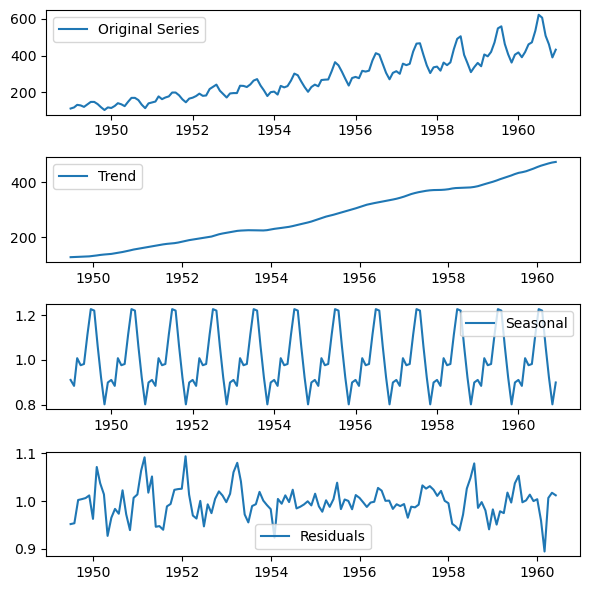

In [6]:
result = seasonal_decompose(df['#Passengers'], model='multiplicative', period=12)
trend = result.trend.dropna()
seasonal = result.seasonal.dropna()
residual = result.resid.dropna()

# Plot the decomposed components
plt.figure(figsize=(6,6))

plt.subplot(4, 1, 1)
plt.plot(df['#Passengers'], label='Original Series')
plt.legend()

plt.subplot(4, 1, 2)
plt.plot(trend, label='Trend')
plt.legend()

plt.subplot(4, 1, 3)
plt.plot(seasonal, label='Seasonal')
plt.legend()

plt.subplot(4, 1, 4)
plt.plot(residual, label='Residuals')
plt.legend()

plt.tight_layout()
plt.show()


**Step 5: Exogenous variable**



In [7]:
df['month_index'] = df.index.month


**Step 6: SARIMAX Model Fitting**
Use pmdarima to automatically fit a Seasonal AutoRegressive Integrated Moving Average with eXogenous variables (SARIMAX) model to the ‘AirPassengers’ data. The parameters are set for automatic selection based on the Akaike Information Criterion (AIC) through the ‘auto_arima’ function.

In [8]:
SARIMAX_model = pm.auto_arima(df[['#Passengers']], exogenous=df[['month_index']],
						start_p=1, start_q=1,
						test='adf',
						max_p=3, max_q=3, m=12,
						start_P=0, seasonal=True,
						d=None, D=1,
						trace=False,
						error_action='ignore',
						suppress_warnings=True,
						stepwise=True)


**Step 7: SARIMAX forecasting function**
Define a function sarimax_forecast that takes a trained SARIMAX model and generates forecasts for a specified number of periods (24 months in this case). It also plots the original time series, the forecast, and the confidence intervals.

In [9]:
def sarimax_forecast(SARIMAX_model, periods=24):
	# Forecast
	n_periods = periods

	forecast_df = pd.DataFrame({"month_index": pd.date_range(df.index[-1], periods=n_periods, freq='MS').month},
							index=pd.date_range(df.index[-1] + pd.DateOffset(months=1), periods=n_periods, freq='MS'))

	fitted, confint = SARIMAX_model.predict(n_periods=n_periods,
											return_conf_int=True,
											exogenous=forecast_df[['month_index']])
	index_of_fc = pd.date_range(df.index[-1] + pd.DateOffset(months=1), periods=n_periods, freq='MS')

	# make series for plotting purpose
	fitted_series = pd.Series(fitted, index=index_of_fc)
	lower_series = pd.Series(confint[:, 0], index=index_of_fc)
	upper_series = pd.Series(confint[:, 1], index=index_of_fc)

	# Plot
	plt.figure(figsize=(15, 7))
	plt.plot(df["#Passengers"], color='#1f76b4')
	plt.plot(fitted_series, color='darkgreen')
	plt.fill_between(lower_series.index,
					lower_series,
					upper_series,
					color='k', alpha=.15)

	plt.title("SARIMAX - Forecast of Airline Passengers")
	plt.show()


**Step 8: Forecasting**
Call the ‘sarimax_forecast’ function with the trained SARIMAX model and specify the number of periods (here, 24 months) for forecasting. The function will generate the forecast plot based on the SARIMAX model.


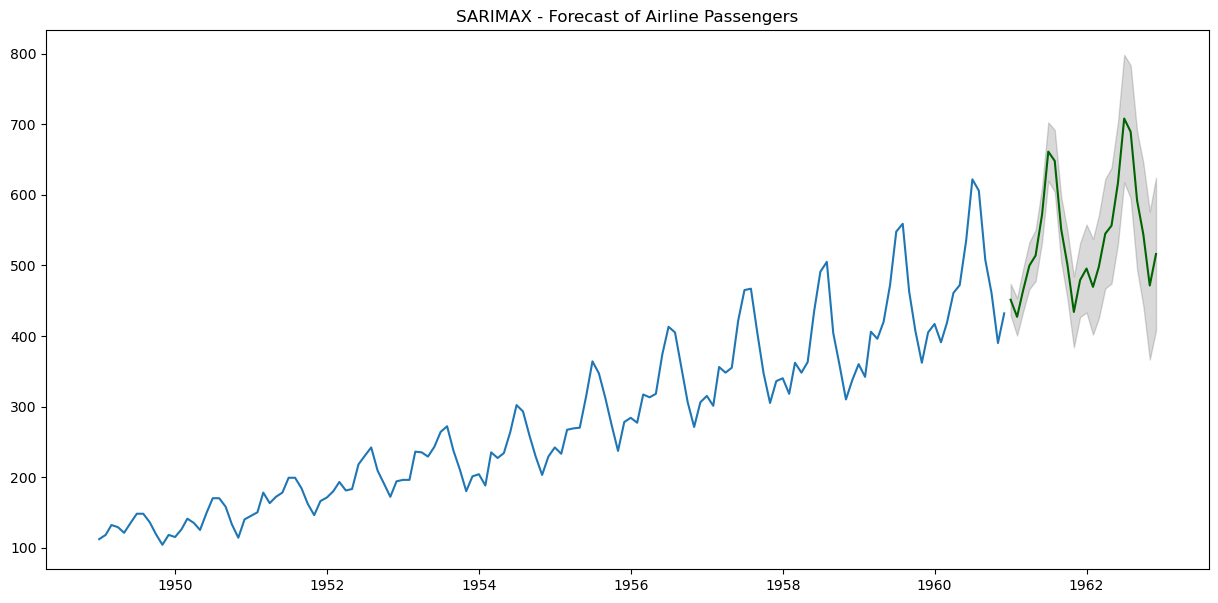

In [10]:
sarimax_forecast(SARIMAX_model, periods=24)
